In [114]:
from supervision.utils.image import crop_image
import os
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from natsort import natsort
import glob
import xml.etree.ElementTree as ET
from PIL import Image as im
import numpy as np
import shutil
import cv2
import supervision as sv

In [75]:
foregroundImagesDir = "/Users/siddhibrahmbhatt/Siddhi/Data/DeepImageBlendingData/ForegroundImages/"
foregroundAnnotationsDir = "/Users/siddhibrahmbhatt/Siddhi/Data/DeepImageBlendingData/ForegroundAnnotations/"
foregroundMasksDir = "/Users/siddhibrahmbhatt/Siddhi/Data/DeepImageBlendingData/ForegroundMasks/"
backgroundImagesDir = "/Users/siddhibrahmbhatt/Siddhi/Data/DeepImageBlendingData/BackgroundImages/"
IP102_ImagesDir = "/Users/siddhibrahmbhatt/Siddhi/Detection_IP102/VOC2007/JPEGImages/"
IP102_AnnotationsDir = "/Users/siddhibrahmbhatt/Siddhi/Detection_IP102/VOC2007/Annotations/"
IP102_SplitsDir = "/Users/siddhibrahmbhatt/Siddhi/Detection_IP102/VOC2007/ImageSets/Main/"

In [76]:
test_split = open(os.path.join(IP102_SplitsDir, "test.txt"))
test_split_lines = test_split.readlines()
trainval_split = open(os.path.join(IP102_SplitsDir, "trainval.txt"))
trainval_split_lines = trainval_split.readlines()

print(len(test_split_lines), test_split_lines[:10], sep="\n")   
print(len(trainval_split_lines), trainval_split_lines[:10], sep="\n")   


i = 1
test_0 = [file for file in test_split_lines if file.startswith("IP001")]
test_01 = [file for file in test_split_lines if file.startswith(f"IP{i:03}")]


#print(len(test_0) , len(test_01))

3798
['IP000000064\n', 'IP000000108\n', 'IP000000544\n', 'IP000000855\n', 'IP000000290\n', 'IP000000564\n', 'IP000000664\n', 'IP000000907\n', 'IP000000633\n', 'IP000000572\n']
15178
['IP000000378\n', 'IP000000782\n', 'IP000000937\n', 'IP000000669\n', 'IP000000573\n', 'IP000000714\n', 'IP000000593\n', 'IP000000306\n', 'IP000000354\n', 'IP000000050\n']


In [105]:
# Check https://docs.google.com/document/d/1cugdLSV2uL71qQvFc3HOvLlG25aP70LzO65OECVUzpo/edit?usp=sharing for discrepancies in IP102 dataset
# IP009000231.xml not present hence IP009000231.jpg deleted to remove the discrepancy.

# Sanity check for IP102 image and annotation files 
# pest classes for rice: 0-13

np.random.seed(0) #random seed for reproducible splits


for i in range(14):

    splits = {}

    source_images = natsort.natsorted(glob.glob(IP102_ImagesDir + f"IP{i:03}*.jpg"))
    source_annotations = natsort.natsorted(glob.glob(IP102_AnnotationsDir + f"IP{i:03}*.xml"))

    print(f"pest class: {i},", f" no of source images: {len(source_images)},", f"no of annotations: {len(source_annotations)}", end="\n")

    temp_trainval = natsort.natsorted([file[:-1] for file in trainval_split_lines if file.startswith(f"IP{i:03}")])
    splits['test'] = natsort.natsorted([file[:-1] for file in test_split_lines if file.startswith(f"IP{i:03}")])

    np.random.shuffle(temp_trainval)
    
    #print(f"no of trainval images: {len(temp_trainval)}", f"no of test images: {len(splits['test'])}", f"addition: {len(temp_trainval) + len(splits['test'])}")

    splits['train']= temp_trainval[ :int(len(temp_trainval) * 0.8)]
    splits['val'] = temp_trainval[int(len(temp_trainval) * 0.8): ]


    print(f"no of train images: {len(splits['train'])}", f"no of test images: {len(splits['test'])}", f"no of val images: {len(splits['val'])}" ,f"addition: {len(splits['train']) + len(splits['test']) + len(splits['val'])}", sep=", ")

    #check split percentages: 64-20-16
    #print(len(splits['train'])/(len(splits['train']) + len(splits['test']) + len(splits['val'])) * 100, len(splits['test'])/(len(splits['train']) + len(splits['test']) + len(splits['val'])) * 100, len(splits['val'])/(len(splits['train']) + len(splits['test']) + len(splits['val'])) * 100)

    for split in ["train", "test", "val"]:

        for fileName in splits[split]:

            shutil.copy2(src = os.path.join(IP102_ImagesDir, f"{fileName}.jpg"), dst= os.path.join(foregroundImagesDir, split))
            shutil.copy2(src = os.path.join(IP102_AnnotationsDir, f"{fileName}.xml"), dst= os.path.join(foregroundAnnotationsDir, split))

    print("Copied the required files")
    print()

pest class: 0,  no of source images: 174, no of annotations: 174
no of train images: 111, no of test images: 35, no of val images: 28, addition: 174
Copied the required files

pest class: 1,  no of source images: 114, no of annotations: 114
no of train images: 72, no of test images: 23, no of val images: 19, addition: 114
Copied the required files

pest class: 2,  no of source images: 25, no of annotations: 25
no of train images: 16, no of test images: 5, no of val images: 4, addition: 25
Copied the required files

pest class: 3,  no of source images: 166, no of annotations: 166
no of train images: 106, no of test images: 33, no of val images: 27, addition: 166
Copied the required files

pest class: 4,  no of source images: 81, no of annotations: 81
no of train images: 52, no of test images: 16, no of val images: 13, addition: 81
Copied the required files

pest class: 5,  no of source images: 93, no of annotations: 93
no of train images: 59, no of test images: 19, no of val images: 15,

In [109]:
for split in ["train", "test", "val"]:

    imageFiles = glob.glob(os.path.join(foregroundImagesDir, split) + "/*.jpg")
    annotationFiles = glob.glob(os.path.join(foregroundAnnotationsDir, split) + "/*.xml")

    print(f"{split} -> no of images: {len(imageFiles)}, no of annotations: {len(annotationFiles)} ")

train -> no of images: 794, no of annotations: 794 
test -> no of images: 250, no of annotations: 250 
val -> no of images: 204, no of annotations: 204 


In [110]:
CHECKPOINT_PATH = "weights/sam_vit_h_4b8939.pth"
DEVICE = "mps"
MODEL_TYPE = "vit_h"


In [112]:
sam = sam_model_registry[MODEL_TYPE](checkpoint = CHECKPOINT_PATH).to(device = DEVICE)
mask_predictor = SamPredictor(sam)


In [127]:
for split in ["train", "test", "val"]:

    imageFiles = natsort.natsorted(glob.glob(os.path.join(foregroundImagesDir, split) + "/*.jpg"))
    annotationFiles = natsort.natsorted(glob.glob(os.path.join(foregroundAnnotationsDir, split) + "/*.xml"))

    print(f"{split} -> no of images: {len(imageFiles)}, no of annotations: {len(annotationFiles)} ")

    for img, ann in zip(imageFiles, annotationFiles):

        
        tree = ET.parse(ann) 
        root = tree.getroot() # get root object

        bbox_coordinates = []
        for member in root.findall('object'):
            class_name = member[0].text # class name
                
            # bbox coordinates
            xmin = int(member[4][0].text)
            ymin = int(member[4][1].text)
            xmax = int(member[4][2].text)
            ymax = int(member[4][3].text)
            # store data in list
            bbox_coordinates.append([xmin, ymin, xmax, ymax])

        box = np.array(bbox_coordinates)[0]

        image_bgr = cv2.imread(img)
        #print(image_bgr)
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

        mask_predictor.set_image(image_rgb)

        masks, scores, logits = mask_predictor.predict(
            box=box,
            multimask_output=True
        )

        #print(masks.shape)

        box_annotator = sv.BoxAnnotator(color=sv.Color.red())
        mask_annotator = sv.MaskAnnotator()

        detections = sv.Detections(
            xyxy=sv.mask_to_xyxy(masks=masks),
            mask=masks
        )

        detections = detections[detections.area == np.max(detections.area)]

        source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
        segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

        # sv.plot_images_grid(
        #     images=[source_image, segmented_image],
        #     grid_size=(1, 2),
        #     titles=['source image', 'segmented image']
        # )

        data = im.fromarray(masks[0])

        mask_save_path = os.path.join(foregroundMasksDir, split) + '/' + os.path.splitext(os.path.basename(img))[0] + '.png'

        data.save(mask_save_path)

    maskFiles = natsort.natsorted(glob.glob(os.path.join(foregroundMasksDir, split) + "/*.png"))
    print(f"no of masks: {len(maskFiles)}")


train -> no of images: 794, no of annotations: 794 
no of masks: 794
test -> no of images: 250, no of annotations: 250 
no of masks: 250
val -> no of images: 204, no of annotations: 204 
no of masks: 204


### Rough work below (to be removed remove later):

/Users/siddhibrahmbhatt/Siddhi/Detection_IP102/VOC2007/JPEGImages/IP000000000.jpg /Users/siddhibrahmbhatt/Siddhi/Detection_IP102/VOC2007/Annotations/IP000000000.xml
(3, 420, 650)


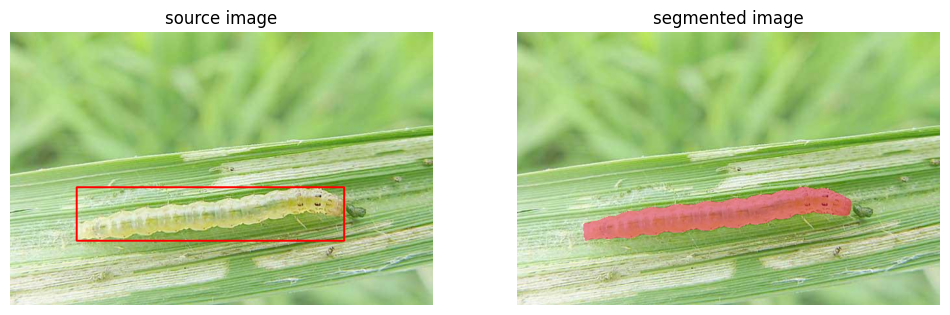

/Users/siddhibrahmbhatt/Siddhi/Detection_IP102/VOC2007/JPEGImages/IP000000002.jpg /Users/siddhibrahmbhatt/Siddhi/Detection_IP102/VOC2007/Annotations/IP000000002.xml
(3, 300, 400)


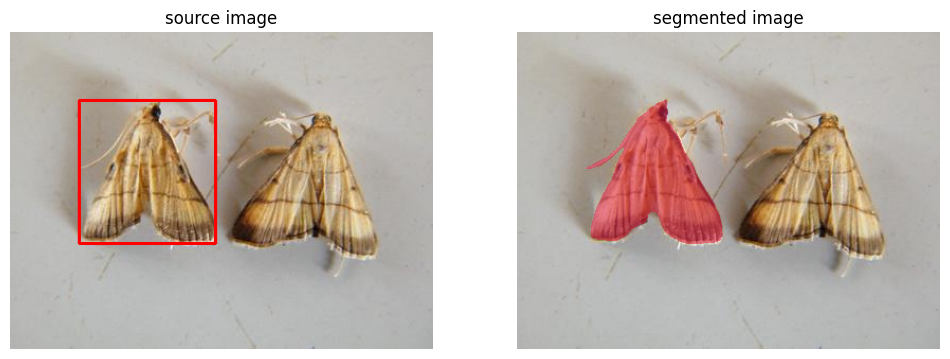

/Users/siddhibrahmbhatt/Siddhi/Detection_IP102/VOC2007/JPEGImages/IP000000003.jpg /Users/siddhibrahmbhatt/Siddhi/Detection_IP102/VOC2007/Annotations/IP000000003.xml
(3, 848, 1146)


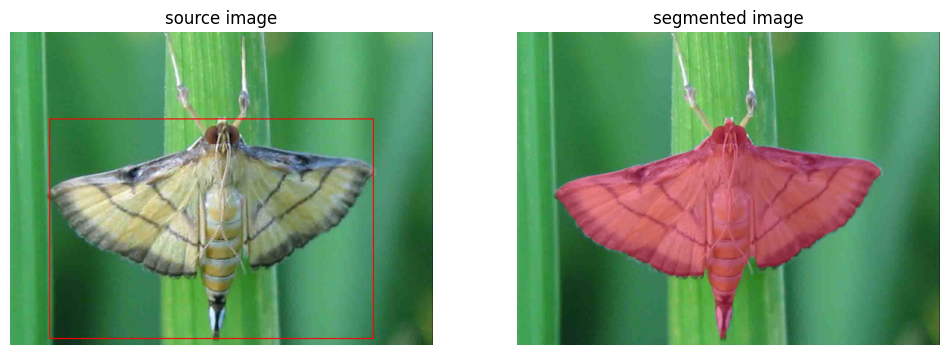

/Users/siddhibrahmbhatt/Siddhi/Detection_IP102/VOC2007/JPEGImages/IP000000008.jpg /Users/siddhibrahmbhatt/Siddhi/Detection_IP102/VOC2007/Annotations/IP000000008.xml
(3, 394, 480)


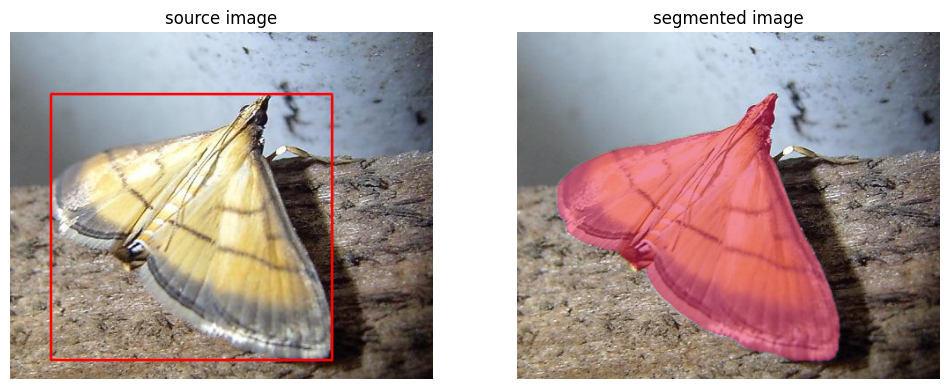

/Users/siddhibrahmbhatt/Siddhi/Detection_IP102/VOC2007/JPEGImages/IP000000010.jpg /Users/siddhibrahmbhatt/Siddhi/Detection_IP102/VOC2007/Annotations/IP000000010.xml
(3, 341, 449)


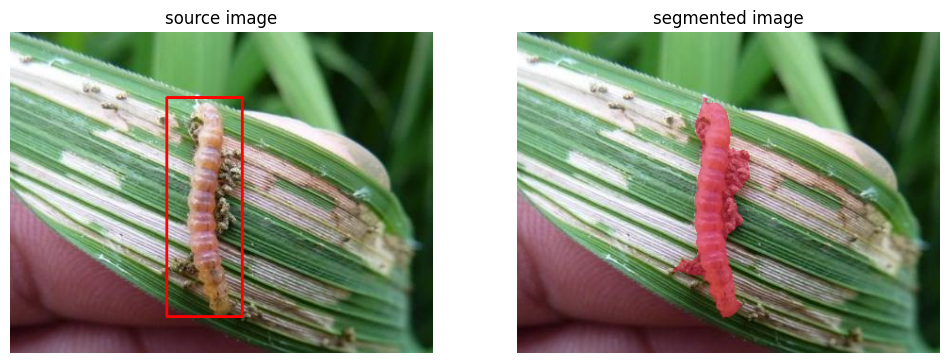

/Users/siddhibrahmbhatt/Siddhi/Detection_IP102/VOC2007/JPEGImages/IP000000031.jpg /Users/siddhibrahmbhatt/Siddhi/Detection_IP102/VOC2007/Annotations/IP000000031.xml
(3, 800, 1200)


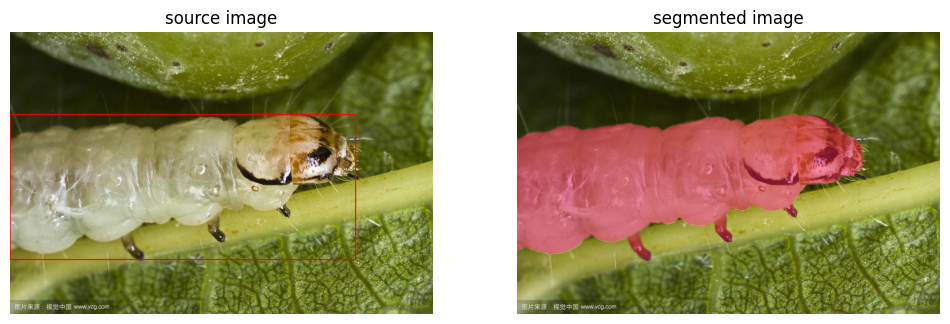

/Users/siddhibrahmbhatt/Siddhi/Detection_IP102/VOC2007/JPEGImages/IP000000042.jpg /Users/siddhibrahmbhatt/Siddhi/Detection_IP102/VOC2007/Annotations/IP000000042.xml
(3, 1536, 2048)


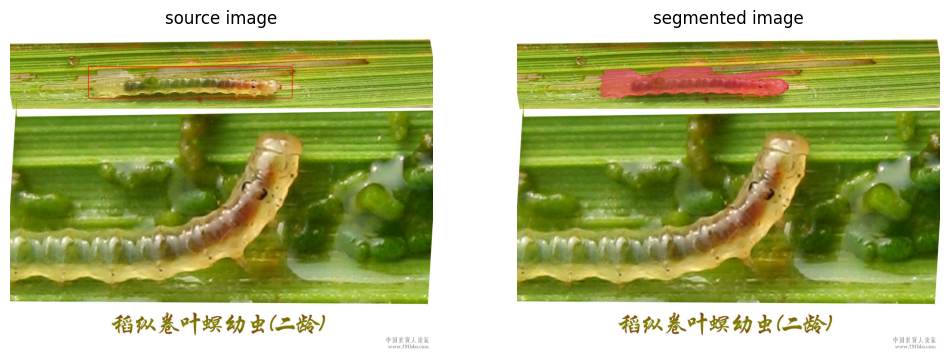

/Users/siddhibrahmbhatt/Siddhi/Detection_IP102/VOC2007/JPEGImages/IP000000044.jpg /Users/siddhibrahmbhatt/Siddhi/Detection_IP102/VOC2007/Annotations/IP000000044.xml
(3, 192, 300)


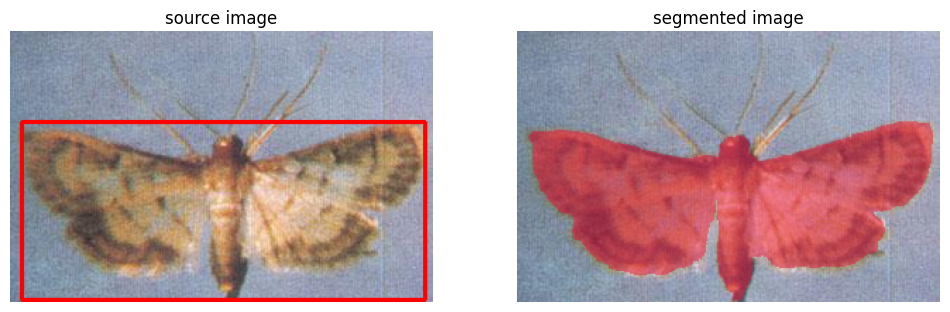

/Users/siddhibrahmbhatt/Siddhi/Detection_IP102/VOC2007/JPEGImages/IP000000046.jpg /Users/siddhibrahmbhatt/Siddhi/Detection_IP102/VOC2007/Annotations/IP000000046.xml
(3, 183, 300)


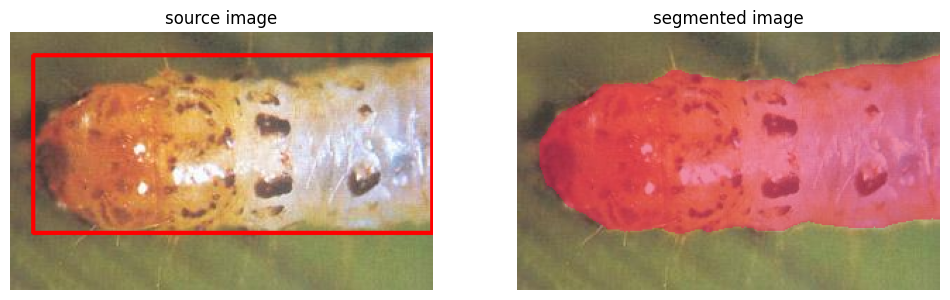

/Users/siddhibrahmbhatt/Siddhi/Detection_IP102/VOC2007/JPEGImages/IP000000047.jpg /Users/siddhibrahmbhatt/Siddhi/Detection_IP102/VOC2007/Annotations/IP000000047.xml
(3, 526, 690)


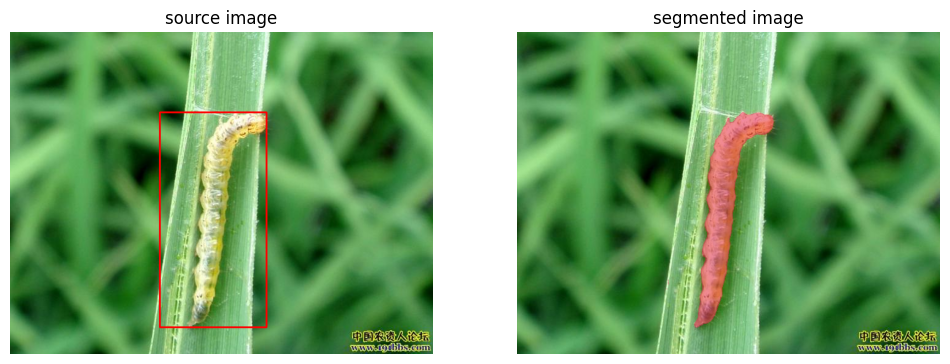

In [92]:
# mask_predictor = SamPredictor(sam)


# save_path = os.path.join(DATA_DIRECTORY, str(pestclass))

# i = 0

# for img, ann in zip(source_images[:10], source_annotations[:10]):

#     print(img, ann)
    
#     tree = ET.parse(ann) 
#     root = tree.getroot() # get root object

#     bbox_coordinates = []
#     for member in root.findall('object'):
#         class_name = member[0].text # class name
            
#         # bbox coordinates
#         xmin = int(member[4][0].text)
#         ymin = int(member[4][1].text)
#         xmax = int(member[4][2].text)
#         ymax = int(member[4][3].text)
#         # store data in list
#         bbox_coordinates.append([xmin, ymin, xmax, ymax])

#     box = np.array(bbox_coordinates)[0]

#     image_bgr = cv2.imread(img)
#     #print(image_bgr)
#     image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

#     mask_predictor.set_image(image_rgb)

#     masks, scores, logits = mask_predictor.predict(
#         box=box,
#         multimask_output=True
#     )

#     print(masks.shape)

#     box_annotator = sv.BoxAnnotator(color=sv.Color.red())
#     mask_annotator = sv.MaskAnnotator()

#     detections = sv.Detections(
#         xyxy=sv.mask_to_xyxy(masks=masks),
#         mask=masks
#     )

#     detections = detections[detections.area == np.max(detections.area)]

#     source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
#     segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

#     sv.plot_images_grid(
#         images=[source_image, segmented_image],
#         grid_size=(1, 2),
#         titles=['source image', 'segmented image']
#     )

#     data = im.fromarray(masks[0])


#     data.save(f'{save_path}/mask_{i}.png')

#     i += 1

    

In [ ]:
# for i in range(51):

#     print(source_images[i][-7:], source_annotations[i][-7:])


# #problem that 231.xml not present

000.jpg 000.xml
002.jpg 002.xml
003.jpg 003.xml
009.jpg 009.xml
031.jpg 031.xml
032.jpg 032.xml
033.jpg 033.xml
058.jpg 058.xml
059.jpg 059.xml
091.jpg 091.xml
097.jpg 097.xml
105.jpg 105.xml
106.jpg 106.xml
108.jpg 108.xml
111.jpg 111.xml
113.jpg 113.xml
115.jpg 115.xml
116.jpg 116.xml
118.jpg 118.xml
123.jpg 123.xml
128.jpg 128.xml
148.jpg 148.xml
151.jpg 151.xml
166.jpg 166.xml
167.jpg 167.xml
174.jpg 174.xml
177.jpg 177.xml
181.jpg 181.xml
231.jpg 235.xml
235.jpg 247.xml
247.jpg 249.xml
249.jpg 250.xml
250.jpg 265.xml
265.jpg 268.xml
268.jpg 405.xml
405.jpg 407.xml
407.jpg 412.xml
412.jpg 416.xml
416.jpg 428.xml
428.jpg 449.xml
449.jpg 452.xml
452.jpg 454.xml
454.jpg 455.xml
455.jpg 473.xml
473.jpg 477.xml
477.jpg 486.xml
486.jpg 494.xml
494.jpg 495.xml
495.jpg 496.xml
496.jpg 502.xml


IndexError: list index out of range

In [17]:
# mask_predictor = SamPredictor(sam)

# IMAGE_NAME = "IP000000002.jpg"
# IMAGE_PATH = os.path.join(IMAGES_DIRECTORY, IMAGE_NAME)

# ANNOTATION_NAME = "IP000000002.xml"
# ANNOTATION_PATH = os.path.join(ANNOTATIONS_DIRECTORY, ANNOTATION_NAME)

In [18]:

# # parse xml file
# tree = ET.parse(ANNOTATION_PATH) 
# root = tree.getroot() # get root object

In [20]:
# bbox_coordinates = []
# for member in root.findall('object'):
#     class_name = member[0].text # class name
        
#     # bbox coordinates
#     xmin = int(member[4][0].text)
#     ymin = int(member[4][1].text)
#     xmax = int(member[4][2].text)
#     ymax = int(member[4][3].text)
#     # store data in list
#     bbox_coordinates.append([xmin, ymin, xmax, ymax])

# print(bbox_coordinates)

[[54, 61, 196, 204], [207, 61, 352, 221]]


In [21]:
# import numpy as np

# # # default_box is going to be used if you will not draw any box on image above
# # default_box = {'x': 207, 'y': 61, 'width': 352 - 207 , 'height': 221-61, 'label': ''}

# # #box = widget.bboxes[0] if widget.bboxes else default_box
# # box = default_box
# # box = np.array([
# #     box['x'],
# #     box['y'],
# #     box['x'] + box['width'],
# #     box['y'] + box['height']
# # ])

# box = np.array(bbox_coordinates[0])

In [22]:
# import cv2
# import numpy as np
# import supervision as sv

# image_bgr = cv2.imread(IMAGE_PATH)
# #print(image_bgr)
# image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# mask_predictor.set_image(image_rgb)

# masks, scores, logits = mask_predictor.predict(
#     box=box,
#     multimask_output=True
# )

# print(masks.shape)

(3, 300, 400)


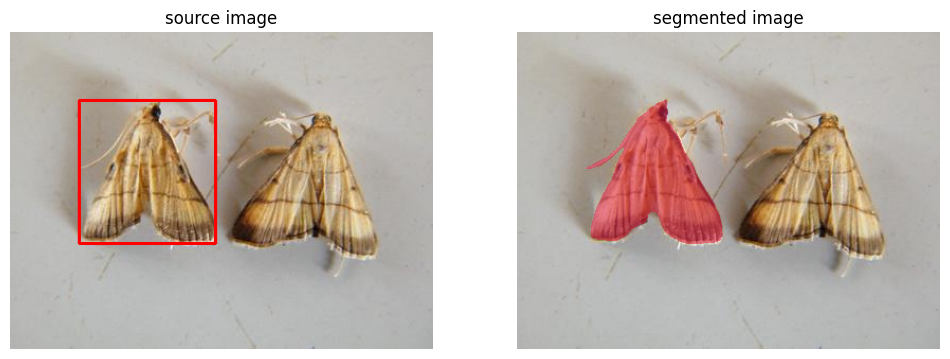

In [23]:
# box_annotator = sv.BoxAnnotator(color=sv.Color.red())
# mask_annotator = sv.MaskAnnotator()

# detections = sv.Detections(
#     xyxy=sv.mask_to_xyxy(masks=masks),
#     mask=masks
# )

# detections = detections[detections.area == np.max(detections.area)]

# source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
# segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

# sv.plot_images_grid(
#     images=[source_image, segmented_image],
#     grid_size=(1, 2),
#     titles=['source image', 'segmented image']
# )

In [24]:

# print(masks[0].shape)

# data = im.fromarray(masks[0])


# data.save('mask.png')

(300, 400)
